In [1]:
import pathlib
import pandas as pd
from tvtk.api import tvtk
from tvtk.common import configure_input, configure_source_data
from tvtk.common import configure_connection, configure_input, configure_input_data, configure_outputs
import gridded 
import xarray as xr
import scipy.interpolate
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from cmcrameri import cm


In [2]:
def grid2poly(grid):
    points = grid.nodes
    
    face_coords_mask = np.dstack([grid.faces.mask, grid.faces.mask])
    face_coords = np.ma.masked_array(
        grid.nodes[grid.faces], 
        face_coords_mask
    )


    # select faces that we need to duplicate
    # TODO: duplicate these (with nodes moved to other end of the world) (mod something...)
    x_max, y_max = face_coords.max(axis=(1)).T
    x_min, y_min = face_coords.min(axis=(1)).T
    mask = (x_min < -150) & (x_max > 150) 

    # Select faces
    faces = grid.faces[~mask]


    # points[:, 0] = np.mod(points[:, 0], 360)
    n_cells = faces.shape[0]

    cell_array = tvtk.CellArray()

    counts = (~faces.mask).sum(axis=1)
    assert faces.min() >= 0, 'expected 0 based faces'
    cell_idx = np.c_[counts, faces.filled(-999)].ravel()
    cell_idx = cell_idx[cell_idx != -999]
    cell_array.set_cells(n_cells, cell_idx)

    # fill in the properties
    polydata = tvtk.PolyData()
    # fill in z dimension
    polydata.points = np.c_[points, np.zeros_like(points[:, 0])]
    polydata.polys = cell_array
    return polydata

def update_data(path, polydata, t=0):
    ds = netCDF4.Dataset(path)
    for key in ['water_level', 'water_level_surge']:
        arr = ds.variables[key][t, ...]
        array = tvtk.FloatArray()
        array.from_array(arr)
        array.name = key
        polydata.cell_data.add_array(array)
    polydata.modified()
    ds.close()

In [3]:
a = tvtk.DoubleArray()
a.print_traits()

_in_set:                 0
_vtk_obj:                (vtkmodules.vtkCommonCore....oubleArray)0x7ff67d50f100
actual_memory_size:      0
array_type:              2
class_name:              'vtkDoubleArray'
data_size:               0
data_type:               11
data_type_as_string:     'double'
data_type_max:           1e+299
data_type_min:           -1e+299
data_type_size:          8
data_type_value_max:     1e+299
data_type_value_min:     -1e+299
debug:                   False
debug_:                  0
element_component_size:  8
finite_range:            (1e+299, -1e+299)
global_warning_display:  1
global_warning_display_: 1
information:             <tvtk.tvtk_classes.informa...object at 0x7ff67d42ec20>
lookup_table:            None
m_time:                  75
max_discrete_values:     32
max_id:                  -1
max_norm:                0.0
name:                    None
number_of_components:    1
number_of_tuples:        0
number_of_values:        0
range:                   (1e+299, -

In [4]:
# f = files[4]
# ds = netCDF4.Dataset(f)
# grid = gridded.pyugrid.ugrid.UGrid.from_nc_dataset(ds)
    
# # same mask as faces, but stacked in 3rd dimension (x, y)
# face_coords_mask = np.dstack([grid.faces.mask, grid.faces.mask])
# face_coords = np.ma.masked_array(
#     grid.nodes[grid.faces], 
#     face_coords_mask
# )

# x_max, y_max = face_coords.max(axis=(1)).T
# x_min, y_min = face_coords.min(axis=(1)).T
# mask = (x_min < -150) & (x_max > 150) 

# x_max, y_max = face_coords.max(axis=(1)).T
# x_min, y_min = face_coords.min(axis=(1)).T
# mask = (x_min < -150) & (x_max > 150) 

# selected_faces = grid.faces[~mask]

# points = grid.nodes


# # points[:, 0] = np.mod(points[:, 0], 360)
# n_cells = selected_faces.shape[0]

# cell_array = tvtk.CellArray()

# counts = (~selected_faces.mask).sum(axis=1)
# assert selected_faces.min() >= 0, 'expected 0 based faces'
# cell_idx = np.c_[counts, selected_faces.filled(-999)].ravel()
# cell_idx = cell_idx[cell_idx != -999]
# cell_array.set_cells(n_cells, cell_idx)

# # fill in the properties
# polydata = tvtk.PolyData()
# # fill in z dimension
# polydata.points = np.c_[points, np.zeros_like(points[:, 0])]
# polydata.polys = cell_array

In [5]:
def setup_pipeline(polydata, width=1000, height=1000):
    # resample = tvtk.PResampleFilter()
    resample = tvtk.ResampleToImage()
    cell2point = tvtk.CellDataToPointData()
    # setup the pipeline
    configure_input(cell2point, polydata)

    configure_input(resample, cell2point)

    resample.sampling_dimensions = np.array([width, height, 1])

    # TODO: check if this can be left out
    resample.modified()
    resample.update()
    polydata.modified()
    return resample


In [6]:
resample = tvtk.ResampleToImage()
resample.print_traits()

_in_set:                           0
_vtk_obj:                          (vtkmodules.vtkFilter...Image)0x7ff67d390e80
abort_execute:                     0
abort_execute_:                    0
class_name:                        'vtkResampleToImage'
debug:                             False
debug_:                            0
error_code:                        0
executive:                         <tvtk.tvtk_classes.co...t at 0x7ff67d439180>
global_warning_display:            1
global_warning_display_:           1
information:                       <tvtk.tvtk_classes.in...t at 0x7ff67d439180>
input_algorithm:                   None
input_connection:                  None
input_executive:                   None
input_information:                 None
m_time:                            79
number_of_input_ports:             1
number_of_output_ports:            1
output:                            <tvtk.tvtk_classes.im...t at 0x7ff67d40b2c0>
output_port:                       <tvtk.tvtk_classe

In [7]:
# data_dir = '/Users/baart_f/data/gtsm/glossis'
data_dir = '/data/glossis'
img_size = (1000, 1000)




In [8]:
path = pathlib.Path(data_dir)
files = list(path.glob('*.nc'))

polydatas_by_name = {}
# apf = tvtk.AppendPolyData(0)
mbd = tvtk.MultiBlockDataSet()
mbd.number_of_blocks = len(files)

In [9]:
f = files[0]
ds = netCDF4.Dataset(f)
key = 'water_level'

print(ds[key])



<class 'netCDF4._netCDF4.Variable'>
float32 water_level(time, nMesh_face)
    standard_name: sea_surface_height_above_sea_level
    long_name: water_level
    units: m
    _FillValue: -9999.0
    mesh: Mesh
    location: face
    coordinates: Mesh_face_y Mesh_face_x analysis_time
    grid_mapping: crs
unlimited dimensions: 
current shape = (73, 121081)
filling on


In [10]:

for i, f in enumerate(files):
    ds = netCDF4.Dataset(f)
    grid = gridded.pyugrid.ugrid.UGrid.from_nc_dataset(ds)
    polydata =  grid2poly(grid)
    # apf.add_input_data(polydata)
    mbd.set_block(i, polydata)
    polydatas_by_name[f.name] = polydata
    ds.close()
# apf.update()
mbm = tvtk.MultiBlockMergeFilter()
configure_input_data(mbm, mbd)
resample = setup_pipeline(mbm, width=img_size[0], height=img_size[1])

In [11]:

for path in files:
    polydata = polydatas_by_name[path.name]
    update_data(path, polydata, t=0)
resample.update()


In [12]:
mbm.update()


In [13]:
mask = resample.get_output().point_data.get_array(2).to_array()
mask = np.logical_not(mask.reshape(img_size))
surge = resample.get_output().point_data.get_array(1).to_array()
surge = surge.reshape(img_size)
surge = np.ma.masked_array(surge, mask=mask)
wl = resample.get_output().point_data.get_array(0).to_array()
wl = wl.reshape(img_size)
wl = np.ma.masked_array(wl, mask=mask)




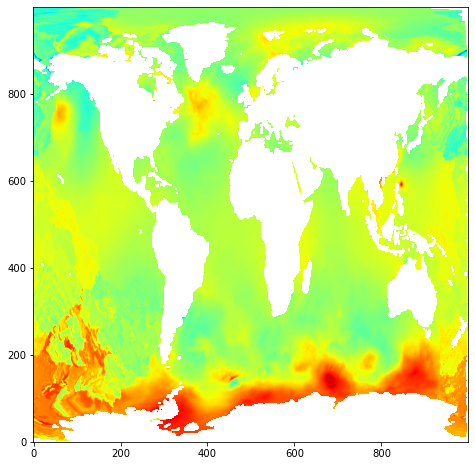

In [19]:
img = resample.get_output()
fig, ax = plt.subplots(figsize=(13, 8))


ax.imshow(surge, origin='lower', cmap='jet')

In [15]:
import rasterio
from rasterio.transform import from_bounds

degree_resolution = 0.05
minx, maxx, miny, maxy = -180, 180, -90, 90

# set x, y to the middle of raster cells
x = np.arange(minx + degree_resolution / 2, maxx, degree_resolution)
y = np.arange(miny + degree_resolution / 2, maxy, degree_resolution)
nx = len(x)
ny = len(y)

tiff_fn = '/data/glossis/test.tiff'

transform = from_bounds(minx, maxy, maxx, miny, nx, ny)
dst = rasterio.open(
    tiff_fn,
    "w",
    driver="GTiff",
    height=ny,
    width=nx,
    count=1,
    dtype="float32",
    crs="epsg:4326",
    transform=transform,
    tiled=True,
    compress="deflate",
)

dst.write_band(1, wl)
dst.update_tags(1, name='waterlevel')

# Add metadata and close file
# dst.update_tags(**metadata)
# dst.update_tags(**time_meta)
dst.close()

In [16]:
writer = tvtk.XMLDataSetWriter()
writer.file_name = '/data/glossis/test.vtp'
configure_input(writer, mbm)
writer.write()

1

In [17]:
writer = tvtk.XMLImageDataWriter()
writer.file_name = '/data/glossis/test.vti'

configure_input(writer, resample)
writer.print_traits()
writer.write()

_in_set:                           0
_vtk_obj:                          (vtkmodules.vtkIOXML....riter)0x7ff66b603940
abort_execute:                     0
abort_execute_:                    0
block_size:                        32768
byte_order:                        'little_endian'
byte_order_:                       1
class_name:                        'vtkXMLImageDataWriter'
compression_level:                 5
compressor:                        <tvtk.tvtk_classes.z_...t at 0x7ff66b5f04f0>
data_mode:                         'appended'
data_mode_:                        2
debug:                             False
debug_:                            0
default_file_extension:            'vti'
encode_appended_data:              1
encode_appended_data_:             1
error_code:                        0
executive:                         <tvtk.tvtk_classes.co...t at 0x7ff66b5f04f0>
file_name:                         '/data/glossis/test.vti'
ghost_level:                       0
global_warning

1

In [18]:
writer = tvtk.TIFFWriter()
writer.file_name = '/data/glossis/test.tiff'

writer.set_input_data(resample.get_output())
# configure_input(writer, resample)
writer.print_traits()
writer.write()

_in_set:                           0
_vtk_obj:                          (vtkmodules.vtkIOImag...riter)0x7ff66b612760
abort_execute:                     0
abort_execute_:                    0
class_name:                        'vtkTIFFWriter'
compression:                       'pack_bits'
compression_:                      1
debug:                             False
debug_:                            0
error_code:                        0
executive:                         <tvtk.tvtk_classes.co...t at 0x7ff67d12b7c0>
file_dimensionality:               2
file_name:                         '/data/glossis/test.tiff'
file_pattern:                      '%s.%d'
file_prefix:                       None
global_warning_display:            1
global_warning_display_:           1
information:                       <tvtk.tvtk_classes.in...t at 0x7ff67d12b7c0>
input:                             <tvtk.tvtk_classes.im...t at 0x7ff67c575cc0>
input_algorithm:                   <tvtk.tvtk_classes.tr...t at 